## **(1) Import Libraries/Modules and Datasets** 

To prepare the Jupyter Notebook, the necessary libraries and modules were imported, and the 'train.csv' and 'test.csv' datasets were read-in. Four columns were removed at the onset, as initial analysis suggested they do not contain information that would be useful for classification algorithms.

In [ ]:
# Install wordclcoud, xgboost, and upgrade seaborn if run locally.
#!pip install wordcloud
#!pip install xgboost
#!pip install seaborn --upgrade

In [ ]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.sparse import csr_matrix
import statsmodels.api as sm
import re
import time
import warnings
from collections import defaultdict, OrderedDict

# Tokenize, Stopwords, and Stemming Text Data
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

# Feature Encoding Text and Categorical Data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Standardization
from sklearn.preprocessing import StandardScaler

# Data Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Train-Test Split
from sklearn.model_selection import train_test_split

# Classification Algorithms and Evaluations
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix

[nltk_data] Downloading package stopwords to C:\Users\Steven
[nltk_data]     Sahakian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Importing training and test datasets.
training_data = pd.read_csv('train.csv')
testing_data = pd.read_csv('test.csv')

# Removing initial features that are not relevant to the analysis such as price, image, reviewTime, and unixReviewTime.
to_drop = ['price', 'image', 'reviewTime', 'unixReviewTime']

# Datasets with dropped columns.
training_data.drop(columns=to_drop, inplace=True)
testing_data.drop(columns=to_drop, inplace=True)

In [ ]:
training_data.head()

overall reviewerID                                         reviewText  \
0      5.0  u92990698  A contemporary jazz and soul performer who's m...   
1      5.0  u36200649  Very good idea to put both the 'pop' and 'orch...   
2      5.0  u10721702  This is a great collection of Carole King's so...   
3      5.0  u86003775  The is album is a brilliant piece of Jazz fusi...   
4      5.0  u25672859  Waited a LONG time for this DVD to be released...   

                                        summary          category     itemID  \
0                                 " CLASSIQUE "              Jazz  p23649501   
1  Exceeded my Expectations - This album RAWKS!  Alternative Rock  p58458313   
2              A Must-have for Carole King Fans               Pop  p97027626   
3                               A Master piece!              Jazz  p43167086   
4         especially if you like concert videos  Alternative Rock  p94494236   

   reviewHash  
0     3856620  
1    56086781  
2    55852154  
3    43228100  
4    54425467

In [ ]:
testing_data.head()

reviewerID                                         reviewText  \
0  u04140621                                                 ok   
1  u74766187  The 1955 and 1958 sets alone are worth the pur...   
2  u31689638  Mary J Blige is someone most people know of. S...   
3  u35613516                              Very good satch album   
4  u93320378  Well there are hundreds of Christmas anthologi...   

                              summary          category     itemID  reviewHash  
0                          Five Stars               Pop  p65721979    98944233  
1  Buy It For the 1955 Set With Monk!              Jazz  p87809670    33903910  
2    Mary's excellent debut! Classic!               Pop  p52702240    35386470  
3                          Four Stars               Pop  p01314374    12404766  
4             CD lives up to its name  Alternative Rock  p84396269    68253688

## **(2) Data Cleaning**

All features in the training DataFrame were analysed to determine the number of null values and the results are displayed below. The only features with missing values are 'reviewText' and 'summary'. Depending on whether an entry is missing only one of these feature values or both, these missing values can be handled in the following manner:

1. Only missing 'reviewText' - replace missing 'reviewText' value with summary value to preserve partial degree of sentiment.
2. Only missing 'summary' - replace missing 'summary' value with 'reviewText' value to preserve sentiment.
3. Missing both 'reviewText' and 'summary' - replace values with 'None' since sentiment cannot be inferred.

A clean training and test dataset were created by replacing all entries with missing values.

In [ ]:
# Analysing all features of training data to determine distribution of missing values.
training_data.isnull().sum(axis = 0)

overall        0
reviewerID     0
reviewText    28
summary       29
category       0
itemID         0
reviewHash     0
dtype: int64

In [ ]:
# Analysing all features of testing data to determine distribution of missing values.
testing_data.isnull().sum(axis = 0)

reviewerID    0
reviewText    3
summary       4
category      0
itemID        0
reviewHash    0
dtype: int64

In [ ]:
# Replace missing 'reviewText' with 'summary' and vice versa. If both are missing, fill with 'None'.
training_data['reviewText'] = training_data['reviewText'].fillna(training_data['summary'])
training_data['summary'] = training_data['summary'].fillna(training_data['reviewText'])
training_data = training_data.fillna('Empty')

testing_data['reviewText'] = testing_data['reviewText'].fillna(testing_data['summary'])
testing_data['summary'] = testing_data['summary'].fillna(testing_data['reviewText'])
testing_data = testing_data.fillna('Empty')

In [ ]:
# Verifying that all null values have been removed from the baseline training dataset.
training_data.isnull().sum(axis=0)

overall       0
reviewerID    0
reviewText    0
summary       0
category      0
itemID        0
reviewHash    0
dtype: int64

In [ ]:
# Verifying that all null values have been removed from the baseline test dataset.
testing_data.isnull().sum(axis=0)

reviewerID    0
reviewText    0
summary       0
category      0
itemID        0
reviewHash    0
dtype: int64

In [ ]:
# Function to convert string to lowercase, tokenize, remove stopwords, stem, and keep only alphanumeric words.
def Text_Clean(row):

  # =============== Description ===============
  '''Input: reference database string row.
  Output: updated database string row with tokenized stemmed lowercase alphanumeric text without stopwords.'''

  # Converts string to lowercase characters.
  row = row.lower()

  # Tokenizing string with alphanumeric words.
  tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_]\w+\'?\w*')
  row = tokenizer.tokenize(row)

  # Removing stopwords.
  row = [word.strip() for word in row if word not in stopwords.words('english')]

  # Stemming each tokenized word.
  stemmed_row = []
  stemmer = SnowballStemmer('english')
  stemmed_row.append(' '.join([stemmer.stem(word) for word in row]))

  return stemmed_row[0]

In [ ]:
training_data_clean = training_data
training_data_clean['reviewText_stemmed'] = training_data['reviewText'].apply(Text_Clean)
training_data_clean['summary_stemmed'] = training_data['summary'].apply(Text_Clean)
training_data_clean

overall reviewerID                                         reviewText  \
0           5.0  u92990698  A contemporary jazz and soul performer who's m...   
1           5.0  u36200649  Very good idea to put both the 'pop' and 'orch...   
2           5.0  u10721702  This is a great collection of Carole King's so...   
3           5.0  u86003775  The is album is a brilliant piece of Jazz fusi...   
4           5.0  u25672859  Waited a LONG time for this DVD to be released...   
...         ...        ...                                                ...   
149995      5.0  u29136602  There is just something about Wesley's voice t...   
149996      5.0  u51715193  How many recordings of Verdis Requiem do you o...   
149997      5.0  u28696060  ....their best overall album.  After the revis...   
149998      5.0  u04925906  Believe it or not, once upon a time, artists l...   
149999      5.0  u79459462  MoKenStef's album is a must have for those who...   

                                                  summary          category  \
0                                           " CLASSIQUE "              Jazz   
1            Exceeded my Expectations - This album RAWKS!  Alternative Rock   
2                        A Must-have for Carole King Fans               Pop   
3                                         A Master piece!              Jazz   
4                   especially if you like concert videos  Alternative Rock   
...                                                   ...               ...   
149995                                        Just right.  Alternative Rock   
149996  Being there  in vibrant immediacy of performan...         Classical   
149997                  Creative rebirth and possibly....  Alternative Rock   
149998                                   Once Upon A Time               Pop   
149999                  An intense album with creativity!               Pop   

           itemID  reviewHash  \
0       p23649501     3856620   
1       p58458313    56086781   
2       p97027626    55852154   
3       p43167086    43228100   
4       p94494236    54425467   
...           ...         ...   
149995  p26326919    90575108   
149996  p69247882    74425587   
149997  p07028930    20399056   
149998  p38606785     5931588   
149999  p07495887    90305896   

                                       reviewText_stemmed  \
0       contemporari jazz soul perform who made two de...   
1       good idea put pop orchestr music matrix reload...   
2                           great collect carol king song   
3       album brilliant piec jazz fusion start finish ...   
4       wait long time dvd releas watch 25 year old vh...   
...                                                   ...   
149995  someth wesley voic make swoon littl bit voic h...   
149996  mani record verdi requiem often ask question s...   
149997  best overal album revisionist fall follow grea...   
149998  believ upon time artist like enchant could see...   
149999  mokenstef album must wanna mellow chill favori...   

                                 summary_stemmed  
0                                       classiqu  
1                       exceed expect album rawk  
2                            must carol king fan  
3                                    master piec  
4                      especi like concert video  
...                                          ...  
149995                                     right  
149996  vibrant immediaci perform spiritu uplift  
149997                   creativ rebirth possibl  
149998                                 upon time  
149999                      intens album creativ  

[150000 rows x 9 columns]

In [ ]:
testing_data_clean = testing_data
testing_data_clean['reviewText_stemmed'] = testing_data['reviewText'].apply(Text_Clean)
testing_data_clean['summary_stemmed'] = testing_data['summary'].apply(Text_Clean)
testing_data_clean

reviewerID                                         reviewText  \
0      u04140621                                                 ok   
1      u74766187  The 1955 and 1958 sets alone are worth the pur...   
2      u31689638  Mary J Blige is someone most people know of. S...   
3      u35613516                              Very good satch album   
4      u93320378  Well there are hundreds of Christmas anthologi...   
...          ...                                                ...   
19995  u16765812  My goodness, Christian Scott has simply taken ...   
19996  u04428712  Congratulations Clan of Xymox - You have butch...   
19997  u39251384  I'm so happy that all of Cher's videos are out...   
19998  u05089888  While I agree with the comments made by Maxwel...   
19999  u99404755  Its almost not fair to have to compare this re...   

                                        summary          category     itemID  \
0                                    Five Stars               Pop  p65721979   
1            Buy It For the 1955 Set With Monk!              Jazz  p87809670   
2              Mary's excellent debut! Classic!               Pop  p52702240   
3                                    Four Stars               Pop  p01314374   
4                       CD lives up to its name  Alternative Rock  p84396269   
...                                         ...               ...        ...   
19995                                Blown Away              Jazz  p17291597   
19996  Take Shelter!  These covers are abysmal!               Pop  p73630774   
19997                        So glad it's here!               Pop  p58275451   
19998                      A personal must-have         Classical  p13155723   
19999                     return of the soulman  Alternative Rock  p88280495   

       reviewHash                                 reviewText_stemmed  \
0        98944233                                                 ok   
1        33903910  1955 1958 set alon worth purchas cost everyth ...   
2        35386470  mari blige someon peopl know first appear clas...   
3        12404766                                   good satch album   
4        68253688  well hundr christma antholog one best ever mix...   
...           ...                                                ...   
19995    66654690  good christian scott simpli taken breath away ...   
19996    55746555  congratul clan xymox butcher 11 classic song w...   
19997    78558928  happi cher video dvd rememb caus child video g...   
19998    84815536  agre comment made maxwel johnson regard sati b...   
19999    85400834  almost fair compar record rest ben harper bodi...   

                summary_stemmed  
0                     five star  
1             buy 1955 set monk  
2      mari excel debut classic  
3                     four star  
4                  cd live name  
...                         ...  
19995                blown away  
19996  take shelter cover abysm  
19997                      glad  
19998               person must  
19999            return soulman  

[20000 rows x 8 columns]

In [ ]:
# Save cleaned DataFrames to CSV file to avoid subsequent runtime.
training_data_clean.to_csv('training_data_clean.csv', index=False)
testing_data_clean.to_csv('testing_data_clean.csv', index=False)

In [ ]:
# Uncomment below to read cleaned CSV files in current directory as DataFrame.
#training_data_clean = pd.read_csv('training_data_clean.csv', keep_default_na=False)
#testing_data_clean = pd.read_csv('testing_data_clean.csv', keep_default_na=False)

## **(3) Exploratory Analysis**

Exploratory analysis includes histograms of music categories (genres) showing frequencies and the distribution of ratings, as well as word clouds for music categories and ratings showing the top frequency words.

### **Summary Counts of Data**

In [ ]:
# Counts of music categories.
training_data_clean['category'].value_counts()

Pop                   68878
Alternative Rock      42776
Jazz                  14850
Classical             14091
Dance & Electronic     9405
Name: category, dtype: int64

In [ ]:
# Counts of ratings to predict.
training_data_clean['overall'].value_counts()

5.0    98213
4.0    29648
3.0    12154
2.0     5213
1.0     4772
Name: overall, dtype: int64

In [ ]:
# Number of unique reviewers.
training_data_clean['reviewerID'].nunique()

63009

In [ ]:
# Number of unique items.
training_data_clean['itemID'].nunique()

24592

### **Visualizations**

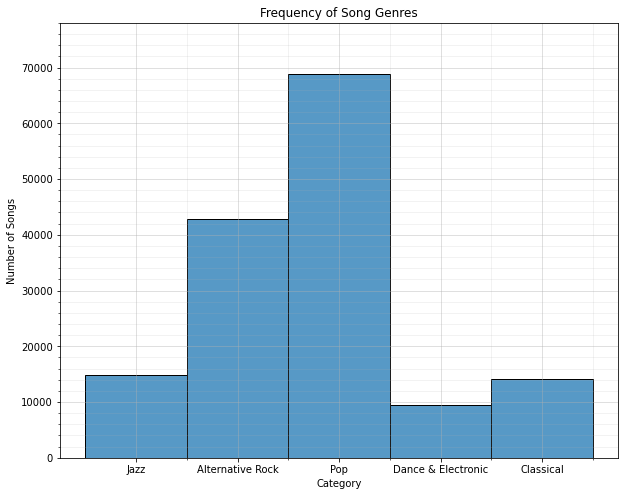

In [ ]:
# Showing the number of songs that belong to each category.
plot = plt.figure(figsize=(10,8))

ax = plt.subplot(1, 1, 1)
sns.histplot(data=training_data_clean, x='category')

plt.xlabel('Category')
plt.ylabel('Number of Songs')
plt.title('Frequency of Song Genres')

y_major_ticks = np.arange(0, 80000, 10000)
y_minor_ticks = np.arange(0, 80000, 2000)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

x_minor_ticks = np.arange(0, 5, 0.5)
ax.set_xticks(x_minor_ticks, minor=True)

# Adding a corresponding grid.
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.savefig('Genre_Frequency')
plt.show()

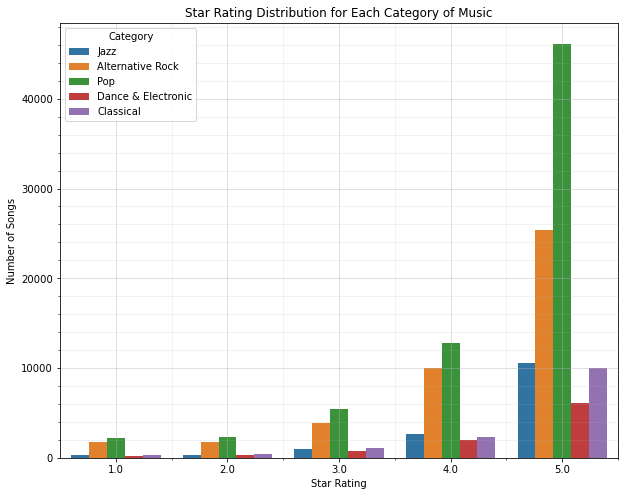

In [ ]:
# Showing the number of songs that belong to each category.
plot = plt.figure(figsize=(10,8))

ax = plt.subplot(1, 1, 1)
sns.countplot(x='overall', hue='category', data=training_data_clean)

plt.xlabel('Star Rating')
plt.ylabel('Number of Songs')
plt.title('Star Rating Distribution for Each Category of Music')
plt.legend(title='Category')

y_major_ticks = np.arange(0, 50000, 10000)
y_minor_ticks = np.arange(0, 50000, 2000)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

x_minor_ticks = np.arange(0, 5, 0.5)
ax.set_xticks(x_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.savefig('Star_Rating_Distribution')
plt.show()

In [ ]:
'''WordCloud function expects a single string of text therefore it is required 
to create a DataFrame that contains the category of music and a combined text of 
all the reviews for the respective categories.'''

jazz = training_data_clean[training_data_clean['category'] == 'Jazz'].groupby('category')['reviewText_stemmed'].apply(' '.join).reset_index()
alt_rock = training_data_clean[training_data_clean['category'] == 'Alternative Rock'].groupby('category')['reviewText_stemmed'].apply(' '.join).reset_index()
pop = training_data_clean[training_data_clean['category'] == 'Pop'].groupby('category')['reviewText_stemmed'].apply(' '.join).reset_index()
edm = training_data_clean[training_data_clean['category'] == 'Dance & Electronic'].groupby('category')['reviewText_stemmed'].apply(' '.join).reset_index()
classical = training_data_clean[training_data_clean['category'] == 'Classical'].groupby('category')['reviewText_stemmed'].apply(' '.join).reset_index()

# Creating an array of the reviews that will be input into the WordCloud function.
jazz_text = jazz.reviewText_stemmed[0]
alt_rock_text = alt_rock.reviewText_stemmed[0]
pop_text = pop.reviewText_stemmed[0]
edm_text = edm.reviewText_stemmed[0]
classical_text = classical.reviewText_stemmed[0]

# Some words that do not provide any insight into the perception of users relating to the overall rating of music can be removed for visualizations.
stopwords = set(STOPWORDS)
stopwords.update(['song', 'songs', 'albums', 'tracks', 'track', 'cd', 'album', 'sound', 'music', 'one', 'band'])

# Creating the word cloud for each genre.
jazz_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(jazz_text)
alt_rock_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(alt_rock_text)
pop_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(pop_text)
edm_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(edm_text)
classical_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(classical_text)

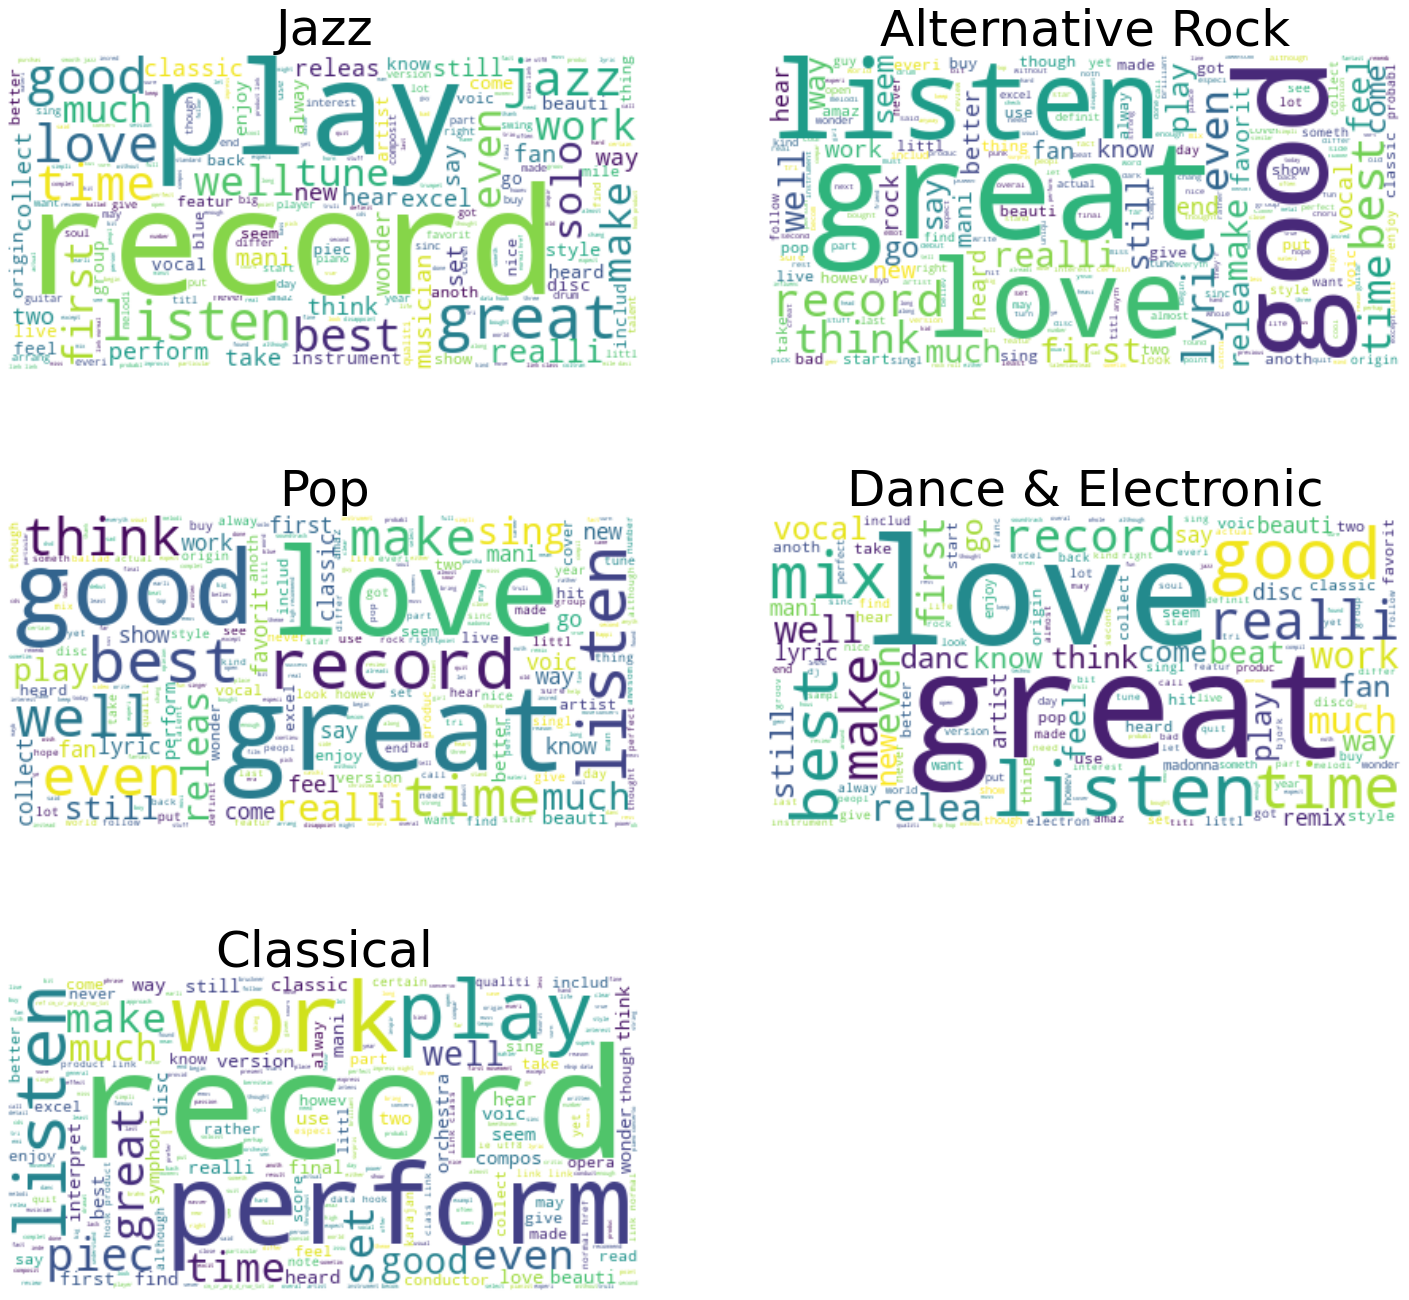

In [ ]:
# Plotting the word clouds for each category.

fig = plt.figure(figsize=(25, 24)) 
fig.add_subplot(3, 2, 1) 
plt.imshow(jazz_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Jazz', fontsize=50)

fig.add_subplot(3, 2, 2) 
plt.imshow(alt_rock_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Alternative Rock', fontsize=50)

fig.add_subplot(3, 2, 3) 
plt.imshow(pop_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Pop', fontsize=50)

fig.add_subplot(3, 2, 4) 
plt.imshow(edm_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Dance & Electronic', fontsize=50)

fig.add_subplot(3, 2, 5) 
plt.imshow(classical_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Classical', fontsize=50)

plt.savefig('Music_Category_Word_Cloud')
plt.show()

In [ ]:
# Top word frequencies for jazz category.
sorted(jazz_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('record', 1.0),
 ('play', 0.9675039872408293),
 ('great', 0.9659090909090909),
 ('listen', 0.717304625199362),
 ('love', 0.6840111642743222),
 ('good', 0.623006379585327),
 ('jazz', 0.6190191387559809),
 ('time', 0.5711722488038278),
 ('best', 0.5081738437001595),
 ('work', 0.40370813397129185),
 ('well', 0.38955342902711326),
 ('make', 0.38237639553429026),
 ('even', 0.37838915470494416),
 ('solo', 0.3714114832535885),
 ('first', 0.3666267942583732),
 ('tune', 0.36403508771929827),
 ('much', 0.3562599681020734),
 ('realli', 0.35566188197767146),
 ('perform', 0.33273524720893144),
 ('releas', 0.33114035087719296)]

In [ ]:
# Top word frequencies for alternative rock category.
sorted(alt_rock_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('great', 1.0),
 ('good', 0.8644123875066173),
 ('listen', 0.7539703546850185),
 ('love', 0.7500661725780836),
 ('record', 0.6590788777130757),
 ('best', 0.645513499205929),
 ('lyric', 0.5266675489677077),
 ('think', 0.5233589200635257),
 ('even', 0.521638433033351),
 ('time', 0.5202488088935945),
 ('realli', 0.49629433562731606),
 ('make', 0.4804790894653256),
 ('well', 0.4799497088406564),
 ('first', 0.44792218104817366),
 ('much', 0.4229089465325569),
 ('still', 0.41774748544203283),
 ('feel', 0.40411593435680254),
 ('relea', 0.37526469031233456),
 ('say', 0.36772101641079935),
 ('play', 0.3665299100052938)]

In [ ]:
# Top word frequencies for pop category.
sorted(pop_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('love', 1.0),
 ('great', 0.9501383647798742),
 ('good', 0.6889559748427673),
 ('record', 0.6091572327044025),
 ('listen', 0.5672452830188679),
 ('best', 0.5209056603773585),
 ('even', 0.4190188679245283),
 ('well', 0.40955974842767295),
 ('time', 0.40623899371069183),
 ('make', 0.4029182389937107),
 ('think', 0.3962767295597484),
 ('realli', 0.38530817610062895),
 ('releas', 0.35683018867924526),
 ('sing', 0.34535849056603773),
 ('much', 0.33242767295597486),
 ('play', 0.3230188679245283),
 ('still', 0.3217106918238994),
 ('lyric', 0.3163270440251572),
 ('first', 0.31466666666666665),
 ('new', 0.3146163522012579)]

In [ ]:
# Top word frequencies for dance and electronic category.
sorted(edm_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('great', 1.0),
 ('love', 0.9979160464423936),
 ('listen', 0.8815123548675201),
 ('good', 0.7904138136350104),
 ('best', 0.6469187258112533),
 ('mix', 0.6418576957427806),
 ('time', 0.5820184578743673),
 ('realli', 0.5617743376004763),
 ('make', 0.5388508484668056),
 ('record', 0.5293242036320334),
 ('relea', 0.5016373920809765),
 ('much', 0.49568323905924383),
 ('first', 0.47871390294730576),
 ('well', 0.4775230723429592),
 ('even', 0.4718666269723132),
 ('work', 0.45370646025602857),
 ('vocal', 0.45043167609407564),
 ('still', 0.4489431378386424),
 ('beat', 0.4364394164930039),
 ('danc', 0.43524858588865734)]

In [ ]:
# Top word frequencies for classical category.
sorted(classical_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('record', 1.0),
 ('perform', 0.7288243739033339),
 ('work', 0.5144361142127931),
 ('play', 0.48923273249322063),
 ('listen', 0.3748604243100973),
 ('piec', 0.3420800765672356),
 ('great', 0.33825171478704735),
 ('set', 0.3186313606635827),
 ('even', 0.3011644600414739),
 ('time', 0.2778752592119955),
 ('make', 0.27548253309937787),
 ('good', 0.2694209602807465),
 ('much', 0.2666294464826926),
 ('well', 0.26256181209124263),
 ('compos', 0.2521933322698995),
 ('disc', 0.24629127452544267),
 ('version', 0.24413782102408677),
 ('symphoni', 0.23943212633593874),
 ('love', 0.23640133992662307),
 ('beauti', 0.2259531025681927)]

In [ ]:
'''WordCloud function expects a single string of text therefore it is required 
to create a DataFrame that contains the rating of music and a combined text of 
all the reviews for the respective ratings.'''

five_star = training_data_clean[training_data_clean['overall'] == 5.0].groupby('overall')['reviewText_stemmed'].apply(' '.join).reset_index()
four_star = training_data_clean[training_data_clean['overall'] == 4.0].groupby('overall')['reviewText_stemmed'].apply(' '.join).reset_index()
three_star = training_data_clean[training_data_clean['overall'] == 3.0].groupby('overall')['reviewText_stemmed'].apply(' '.join).reset_index()
two_star = training_data_clean[training_data_clean['overall'] == 2.0].groupby('overall')['reviewText_stemmed'].apply(' '.join).reset_index()
one_star = training_data_clean[training_data_clean['overall'] == 1.0].groupby('overall')['reviewText_stemmed'].apply(' '.join).reset_index()

# Creating an array of the reviews that will be input into the WordCloud function.
five_star_text = five_star.reviewText_stemmed[0]
four_star_text = four_star.reviewText_stemmed[0]
three_star_text = three_star.reviewText_stemmed[0]
two_star_text = two_star.reviewText_stemmed[0]
one_star_text = one_star.reviewText_stemmed[0]

# Some words that do not provide any insight into the perception of users relating to the overall rating of music can be removed for visualizations.
stopwords = set(STOPWORDS)
stopwords.update(['song', 'songs', 'albums', 'tracks', 'track', 'cd', 'album', 'sound', 'music', 'one', 'band'])

# Creating the word cloud for each rating.
five_star_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(five_star_text)
four_star_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(four_star_text)
three_star_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(three_star_text)
two_star_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(two_star_text)
one_star_wordcloud = WordCloud(stopwords=stopwords, background_color='white', max_words = 500).generate(one_star_text)

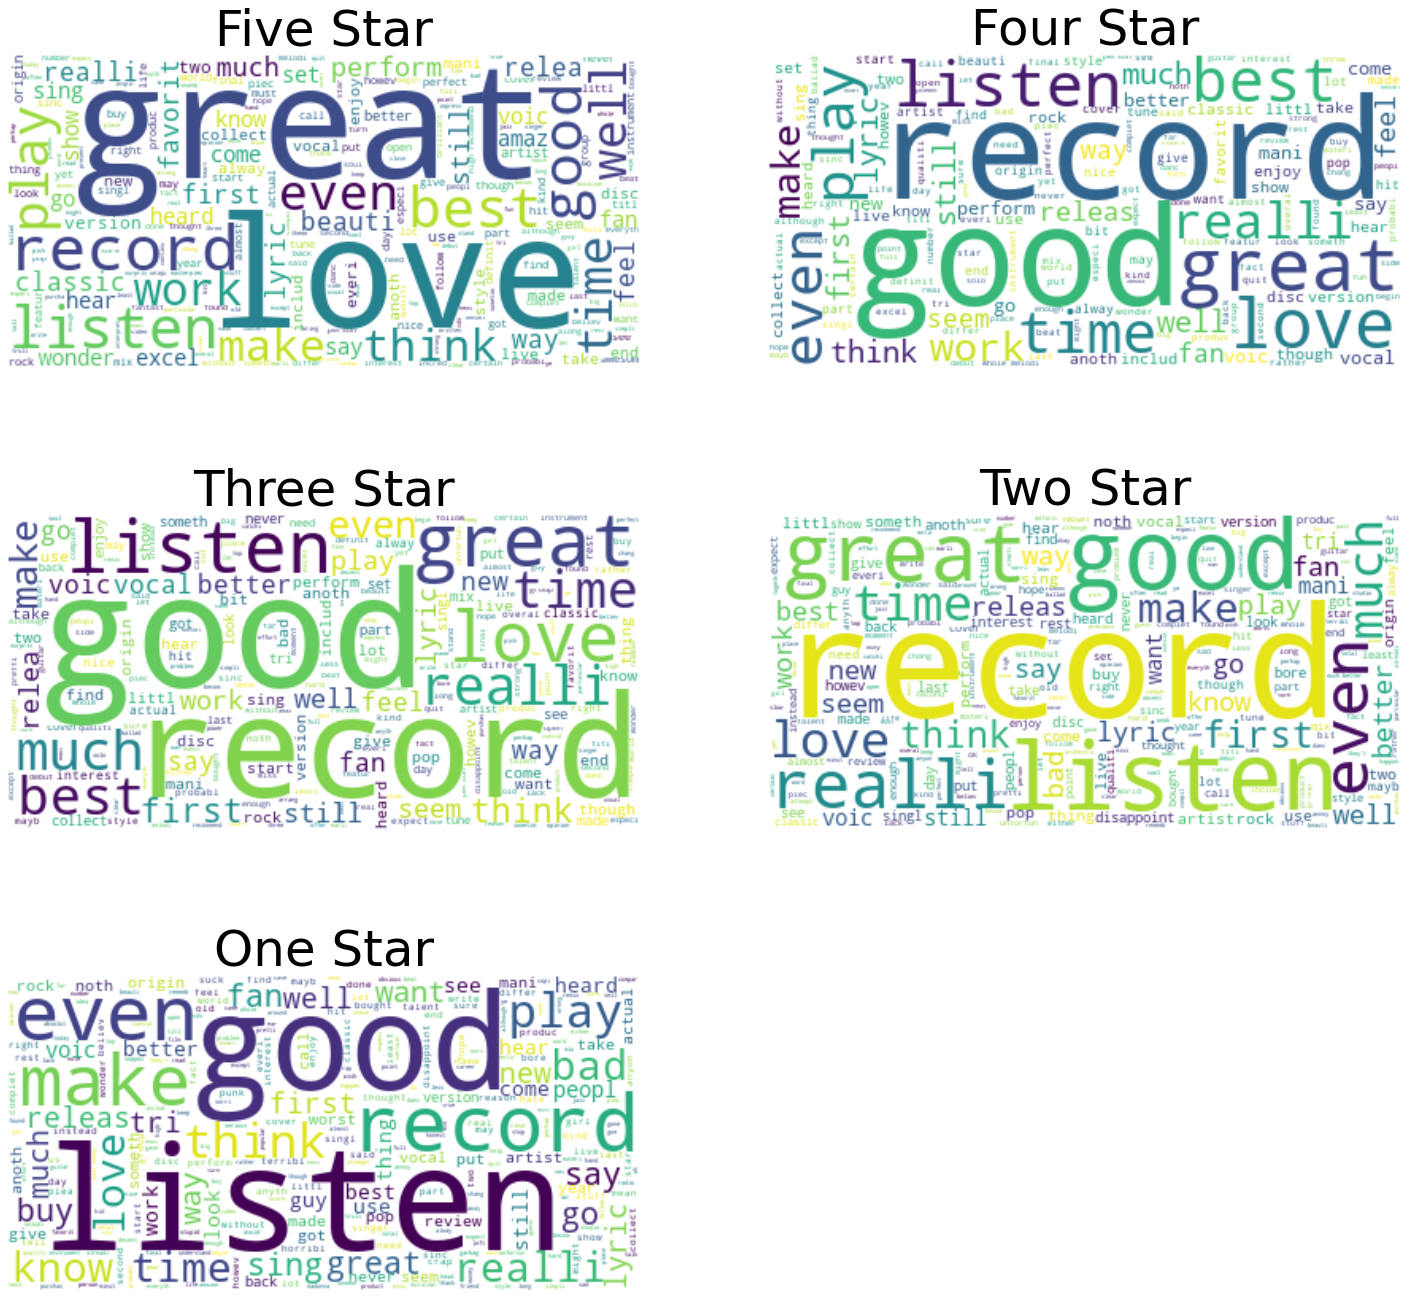

In [ ]:
# Plotting the word cloud for each rating.

fig = plt.figure(figsize=(25, 24)) 
fig.add_subplot(3, 2, 1) 
plt.imshow(five_star_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Five Star', fontsize=50)

fig.add_subplot(3, 2, 2) 
plt.imshow(four_star_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Four Star', fontsize=50)

fig.add_subplot(3, 2, 3) 
plt.imshow(three_star_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Three Star', fontsize=50)

fig.add_subplot(3, 2, 4) 
plt.imshow(two_star_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Two Star', fontsize=50)

fig.add_subplot(3, 2, 5) 
plt.imshow(one_star_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('One Star', fontsize=50)

plt.savefig('Music_Rating_Word_Cloud')
plt.show()

In [ ]:
# Top word frequencies for five star rating.
sorted(five_star_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('great', 1.0),
 ('love', 0.9696092619392185),
 ('record', 0.7410724762389017),
 ('listen', 0.6256502522783275),
 ('good', 0.6040208080729065),
 ('best', 0.5639300661008331),
 ('play', 0.503657057926233),
 ('even', 0.4488207454922361),
 ('time', 0.44103727461180425),
 ('well', 0.4372824343880784),
 ('work', 0.43098525442953806),
 ('think', 0.40086830680173663),
 ('make', 0.3890170923456018),
 ('perform', 0.38440176790393865),
 ('realli', 0.34552352642077677),
 ('first', 0.340986427817108),
 ('beauti', 0.34086908906011654),
 ('much', 0.3395783627332108),
 ('classic', 0.33500215121054483),
 ('relea', 0.3203739195056127)]

In [ ]:
# Top word frequencies for four star rating.
sorted(four_star_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('record', 1.0),
 ('good', 0.9788758607854086),
 ('great', 0.9456541969104784),
 ('love', 0.8427321794155965),
 ('listen', 0.7051926298157454),
 ('best', 0.6275823562255723),
 ('time', 0.5919411874185744),
 ('play', 0.5545319188535269),
 ('even', 0.5525777033314722),
 ('realli', 0.5382467895030709),
 ('work', 0.5346175321049693),
 ('make', 0.5342453005769588),
 ('think', 0.533966126930951),
 ('much', 0.5272659594267635),
 ('well', 0.5207519076865811),
 ('first', 0.49934859482598176),
 ('still', 0.496929089893914),
 ('lyric', 0.4923692536757863),
 ('releas', 0.4605434580308952),
 ('feel', 0.4373720454122464)]

In [ ]:
# Top word frequencies for three star rating.
sorted(three_star_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('good', 1.0),
 ('record', 0.9631362275449101),
 ('great', 0.7572979041916168),
 ('listen', 0.7363398203592815),
 ('love', 0.7035928143712575),
 ('realli', 0.6083458083832335),
 ('much', 0.5907559880239521),
 ('best', 0.5587574850299402),
 ('time', 0.5437874251497006),
 ('even', 0.5271332335329342),
 ('make', 0.5269461077844312),
 ('think', 0.5130988023952096),
 ('first', 0.49550898203592814),
 ('play', 0.4728667664670659),
 ('work', 0.46407185628742514),
 ('still', 0.46145209580838326),
 ('relea', 0.45995508982035926),
 ('seem', 0.45471556886227543),
 ('lyric', 0.43038922155688625),
 ('well', 0.42945359281437123)]

In [ ]:
# Top word frequencies for two star rating.
sorted(two_star_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('record', 1.0),
 ('good', 0.9831127339114559),
 ('listen', 0.9205842081241442),
 ('great', 0.7115472387037882),
 ('realli', 0.7101780009128252),
 ('even', 0.6704701049748973),
 ('time', 0.6449109995435874),
 ('love', 0.6362391602008215),
 ('much', 0.6010953902327705),
 ('make', 0.5901414879050662),
 ('think', 0.5513464171611137),
 ('first', 0.5390232770424463),
 ('releas', 0.5298950251026928),
 ('play', 0.5143769968051118),
 ('best', 0.508443633044272),
 ('seem', 0.5047923322683706),
 ('better', 0.4910999543587403),
 ('lyric', 0.48060246462802375),
 ('well', 0.47466910086718395),
 ('go', 0.4591510725696029)]

In [ ]:
# Top word frequencies for one star rating.
sorted(one_star_wordcloud.words_.items(), key=lambda x:x[1], reverse=True)[:20]

[('listen', 1.0),
 ('good', 0.8443534230544177),
 ('record', 0.8069046225863078),
 ('even', 0.7764774722059684),
 ('make', 0.6553540081919251),
 ('think', 0.5868929198361615),
 ('play', 0.5763604447045055),
 ('realli', 0.5664131070801638),
 ('time', 0.558806319485079),
 ('bad', 0.5435927442949093),
 ('know', 0.5307197191339965),
 ('love', 0.5248683440608543),
 ('great', 0.5125804564072557),
 ('say', 0.5049736688121709),
 ('go', 0.49970743124634287),
 ('sing', 0.49561146869514333),
 ('fan', 0.48507899356348744),
 ('buy', 0.47805734347571677),
 ('want', 0.4534815681685196),
 ('way', 0.44587478057343477)]

## **(4) Model Preparation**

### **Feature Selection and Train-Validation Split**

A final set of the features from the cleaned datasets was selected for training and validating models. The best performing set included two categorical features: `category` and `itemID` as well as two text features: `reviewText_stemmed` and `summary_stemmed`. Feature engineering creating new features by combining a few different existing features such as 'reviewerID', 'itemID', and 'category' was also performed, but these combinations did not perform as well as the chosen set.

Furthermore, the training dataset was split into training and validation subsets, for the purposes of training and validating different classification algorithms. The test dataset was not used until the final evaluation with the selected optimal algorithm and hyperparameters. This helped avoid overfitting directly with the test data, as well as reducing the number of training samples and thus computational demand during training.

In [ ]:
# Split the training dataset into training and validation sets.

columns = ['reviewText_stemmed', 'summary_stemmed', 'category', 'itemID']

reviewerID added too many features (upwards of 80000) that did not provide a better score.

X_train, X_val, y_train, y_val = train_test_split(training_data_clean[columns], training_data_clean['overall'], test_size=0.3, random_state=1)

In [ ]:
# Define the test set.
X_test = testing_data_clean[columns]

### **Feature Encoding**

The two categorical data columns were one-hot encoded using the `OneHotEncoder()` function from `sklearn` while the two text data columns used Term Frequency - Inverse Document Frequency (TF-IDF) encoding with the `TfidfVectorizer()` function from `sklearn`.

Encodings were combined using the `ColumnTransformer` function from `sklearn`. Standardization using the `StandardScaler()` function from `sklearn` was attempted on the resulting sparse matrices, but was found to increase the error, so was not included in the final model.

Several combinations of feature sizes were trained to determine a good balance. A maximum of 5000 text encoded features was found to be a good balance between error and computational expense. Using n-grams of size 1 to 3 decreased the error as well with minimal increase in computational effort. The increase in one-hot encoded features provided by the categorical data of the 'reviewerID' feature was found to increase the error, presumably due to the 'curse of dimensionality' with having over 80,000 features. The models performed better without these encoded 'reviewerID' features as noted previously. Overall, TF-IDF text encoding performed better for all trained and validated algorithms compared to Bag of Words, and was used for the final model evaluated on the test set.

In [ ]:
# Performs feature encoding for text (with Bag of Words) and categorical data. Fits to the training data, and transforms the validation and test data.
categorical_features = ['category', 'itemID']

reviewText_stemmed_transformer = CountVectorizer(ngram_range=(1,3), max_features=5000)
summary_transformer = CountVectorizer(ngram_range=(1,3), max_features=5000)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('reviewText_stemmed', reviewText_stemmed_transformer, 'reviewText_stemmed'),
        ('summary', summary_transformer, 'summary_stemmed'),
        ('cat', categorical_transformer, categorical_features)])

BOW_train = preprocessor.fit_transform(X_train)
BOW_val = preprocessor.transform(X_val)
BOW_test = preprocessor.transform(X_test)

print('Training Set:\nNumber of Rows: ', BOW_train.shape[0], '\nNumber of Features: ', BOW_train.shape[1], '\nNumber of Elements: ', BOW_train.nnz)
print('\nValidation Set:\nNumber of Rows: ', BOW_val.shape[0], '\nNumber of Features: ', BOW_val.shape[1], '\nNumber of Elements: ', BOW_val.nnz)
print('\nTest Set:\nNumber of Rows: ', BOW_test.shape[0], '\nNumber of Features: ', BOW_test.shape[1], '\nNumber of Elements: ', BOW_test.nnz)

Training Set:
Number of Rows:  105000 
Number of Features:  32838 
Number of Elements:  5963742

Validation Set:
Number of Rows:  45000 
Number of Features:  32838 
Number of Elements:  2551649

Test Set:
Number of Rows:  20000 
Number of Features:  32838 
Number of Elements:  1113039


In [ ]:
# Performs feature encoding for text (with TF-IDF) and categorical data. Fits to the training data, and transforms the validation and test data.
categorical_features = ['category', 'itemID']

reviewText_stemmed_transformer = TfidfVectorizer(ngram_range=(1,3), norm='l2', max_features=5000)
summary_transformer = TfidfVectorizer(ngram_range=(1,3), norm='l2', max_features=5000)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('reviewText_stemmed', reviewText_stemmed_transformer, 'reviewText_stemmed'),
        ('summary', summary_transformer, 'summary_stemmed'),
        ('cat', categorical_transformer, categorical_features)])

TFIDF_train = preprocessor.fit_transform(X_train)
TFIDF_val = preprocessor.transform(X_val)
TFIDF_test = preprocessor.transform(X_test)

print('Training Set:\nNumber of Rows: ', TFIDF_train.shape[0], '\nNumber of Features: ', TFIDF_train.shape[1], '\nNumber of Elements: ', TFIDF_train.nnz)
print('\nValidation Set:\nNumber of Rows: ', TFIDF_val.shape[0], '\nNumber of Features: ', TFIDF_val.shape[1], '\nNumber of Elements: ', TFIDF_val.nnz)
print('\nTest Set:\nNumber of Rows: ', TFIDF_test.shape[0], '\nNumber of Features: ', TFIDF_test.shape[1], '\nNumber of Elements: ', TFIDF_test.nnz)

Training Set:
Number of Rows:  105000 
Number of Features:  32838 
Number of Elements:  5963742

Validation Set:
Number of Rows:  45000 
Number of Features:  32838 
Number of Elements:  2551649

Test Set:
Number of Rows:  20000 
Number of Features:  32838 
Number of Elements:  1113039


In [ ]:
# Top 500 features (top 30 shown).
keys = preprocessor.get_feature_names()
values = TFIDF_train.sum(axis=0).tolist()
feature_list = dict(zip(keys, values.pop()))
feature_list_top = sorted(feature_list.items(), key=lambda item: item[1], reverse=True)[:500]
feature_list_top[:30]

[('cat__x0_Pop', 48256.0),
 ('cat__x0_Alternative Rock', 29884.0),
 ('cat__x0_Jazz', 10475.0),
 ('cat__x0_Classical', 9865.0),
 ('summary__star', 8522.743543637152),
 ('summary__five', 7810.397289835638),
 ('summary__five star', 7806.036494321198),
 ('cat__x0_Dance & Electronic', 6520.0),
 ('reviewText_stemmed__album', 4936.819724006552),
 ('reviewText_stemmed__great', 4493.99301512048),
 ('reviewText_stemmed__song', 4133.091050214166),
 ('reviewText_stemmed__cd', 3669.798829548025),
 ('reviewText_stemmed__love', 3617.9366393337395),
 ('reviewText_stemmed__good', 3409.2692776463196),
 ('reviewText_stemmed__music', 3399.2193071712813),
 ('reviewText_stemmed__like', 3068.8301439444554),
 ('reviewText_stemmed__one', 2860.951543391241),
 ('summary__great', 2814.0404416622546),
 ('reviewText_stemmed__sound', 2270.7004160493825),
 ('reviewText_stemmed__listen', 2122.9550952467075),
 ('reviewText_stemmed__record', 2057.5522135659903),
 ('summary__album', 2032.7405073586374),
 ('summary__good'

In [ ]:
# Cleans feature strings for visualization.
feature_list_top_cleaned = OrderedDict()
for i in range(0, len(feature_list_top)):
  key = str(feature_list_top[i][0]).replace('cat__x0_', '').replace('summary__', '').replace('reviewText_stemmed__', '')
  value = feature_list_top[i][1]
  feature_list_top_cleaned[key] = value
list(feature_list_top_cleaned.items())[:30]

[('Pop', 48256.0),
 ('Alternative Rock', 29884.0),
 ('Jazz', 10475.0),
 ('Classical', 9865.0),
 ('star', 788.0708541941644),
 ('five', 298.0587738278548),
 ('five star', 7806.036494321198),
 ('Dance & Electronic', 6520.0),
 ('album', 2032.7405073586374),
 ('great', 2814.0404416622546),
 ('song', 682.2362979983209),
 ('cd', 1475.7934814010418),
 ('love', 1656.6675325929555),
 ('good', 2030.1826408774862),
 ('music', 1442.5701242032046),
 ('like', 801.5359214117639),
 ('one', 1071.9145766120268),
 ('sound', 603.2497103037065),
 ('listen', 479.18899017580264),
 ('record', 561.6984747827343),
 ('best', 1761.6233085949036),
 ('track', 1839.9598021676068),
 ('band', 474.66464320842294),
 ('time', 524.6414969034427),
 ('get', 518.0030029702554),
 ('realli', 351.8125382366053),
 ('excel', 838.1780088943113),
 ('first', 309.4489453953399),
 ('fan', 424.53630879656396),
 ('play', 1373.535544884609)]

In [ ]:
# Clean feature strings by category and text.
feature_list_top_cat = {}
feature_list_top_text = {}

for i in range(0, len(feature_list_top)):

  if 'cat__x0_' in str(feature_list_top[i][0]):
    feature_list_top_cat[str(feature_list_top[i][0]).replace('cat__x0_', '')] = feature_list_top[i][1]
  elif 'summary__' or 'reviewText_stemmed__' in str(feature_list_top[i][0]):
    feature_list_top_text[str(feature_list_top[i][0]).replace('summary__', '').replace('reviewText_stemmed__', '')] = feature_list_top[i][1]

list(feature_list_top_text.items())[:10]

[('star', 788.0708541941644),
 ('five', 298.0587738278548),
 ('five star', 7806.036494321198),
 ('album', 2032.7405073586374),
 ('great', 2814.0404416622546),
 ('song', 682.2362979983209),
 ('cd', 1475.7934814010418),
 ('love', 1656.6675325929555),
 ('good', 2030.1826408774862),
 ('music', 1442.5701242032046)]

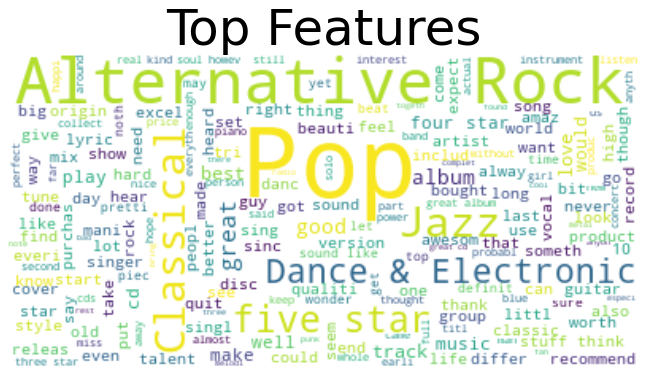

In [ ]:
# Word cloud of top features.
top_features_wordcloud = WordCloud(background_color='white').generate_from_frequencies(feature_list_top_cleaned)
fig = plt.figure(figsize=(25, 24))
fig.add_subplot(3, 2, 1)
plt.imshow(top_features_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Features', fontsize=50)
plt.savefig('Top_Features_Word_Cloud')
plt.show()

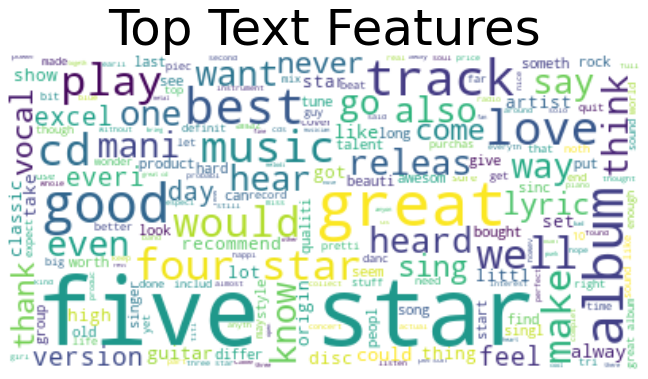

In [ ]:
# Word cloud of top text features only.
top_features_wordcloud = WordCloud(background_color='white').generate_from_frequencies(feature_list_top_text)
fig = plt.figure(figsize=(25, 24))
fig.add_subplot(3, 2, 1)
plt.imshow(top_features_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Text Features', fontsize=50)
plt.savefig('Top_Features_Word_Cloud')
plt.show()

## **(5) Model Implementation and Tuning**

Seven different algorithms for classification are used, fitted to the training set and tested on the validation set. Each algorithm was trained using Bag of Words and TF-IDF in combination with categorical feature encodings. The algorithms included: Multiclass Logistic Regression, k-Nearest Neighbour (KNN), Support Vector Machine (SVM) / Linear SVC, Naive Bayes, XGBoost, Random Forest, and Decision Tree. The classifiers used were: `sklearn.linear_model.LogisticRegression`, `sklearn.neighbors.KNeighborsClassifier`, `sklearn.naive_bayes.MultinomialNB`, `sklearn.svm.LinearSVC`, `sklearn.tree.DecisionTreeClassifier`, `sklearn.ensemble.RandomForestClassifier`, and `xgboost.XGBClassifier`.

The metric for evaluation was mean squared error (MSE) and was determined from the model predictions on the validation data.

Various hyperparameters were tuned and tested using both manual grid search for a bulk assessment of hyperparameter effect, as well as trial-and-error for specific instances. Hyperparameters were tuned for each of the algorithms, but only a subset of those are shown below. It is noted that many algorithms that involved Bag of Words encoding and L1-regularization were computationally expensive due to the nature of the algorithms and fitting them to the large dataset size with a large number of features. As such, grid search is shown for a few of the models below. Logistic Regression with TF-IDF text feature encoding performed the best overall when considering accuracy and speed.

### **Multiclass Logistic Regression Classifier**

In [ ]:
def LR(X_train, X_test, y_train, y_test):

  # Initialize variables to store best model.
  best_model = 0
  best_MSE = 100
  best_pred = 0

  # Grid search for hyperparameter tuning.
  for C in [10.0, 2.0, 1.0, 0.5, 0.1, 0.01]:

    # Classification algorithm, predictions, and MSE.
    model = LogisticRegression(C=C, solver='saga', max_iter=5000, random_state=1)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, pred)
    
    # Print results for each combination in grid search.
    print('C: {}, MSE: {}'.format(C, MSE))

    # Save best model.
    if MSE < best_MSE:
      best_model = model
      best_MSE = MSE
      best_pred = pred
    
  print('\nBest MSE of Logistic Regression:', best_MSE)

  return best_MSE, best_model, best_pred

In [ ]:
# Starting to record elapsed runtime for stats purposes.
start = time.time()

LR_BOW = LR(BOW_train, BOW_val, y_train, y_val)

# Determine elapsed runtime for stats purposes.
print('\nRuntime (s): ', round(time.time()-start, 2))

C: 10.0, MSE: 0.6738444444444445
C: 2.0, MSE: 0.6752
C: 1.0, MSE: 0.6754444444444444
C: 0.5, MSE: 0.6775555555555556
C: 0.1, MSE: 0.6959777777777778
C: 0.01, MSE: 0.8085111111111111

Best MSE of Logistic Regression: 0.6738444444444445

Runtime (s):  3288.45


In [ ]:
start = time.time()
LR_TFIDF = LR(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

C: 10.0, MSE: 0.6895333333333333
C: 2.0, MSE: 0.6382444444444444
C: 1.0, MSE: 0.6406444444444445
C: 0.5, MSE: 0.6688888888888889
C: 0.1, MSE: 0.8567777777777777
C: 0.01, MSE: 1.2516666666666667

Best MSE of Logistic Regression: 0.6382444444444444

Runtime (s):  443.2


### **k-Nearest Neighbor Classifier**

In [ ]:
def KNN(X_train, X_test, y_train, y_test):

  # Classification algorithm, predictions, and MSE.
  model = KNeighborsClassifier()
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, pred)

  print('MSE of k-Nearest Neighbor:', MSE)

  return MSE, model, pred

In [ ]:
start = time.time()
KNN_BOW = KNN(BOW_train, BOW_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

MSE of k-Nearest Neighbor: 1.2392

Runtime (s):  196.32


In [ ]:
start = time.time()
KNN_TFIDF = KNN(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

MSE of k-Nearest Neighbor: 1.2090222222222222

Runtime (s):  192.65


### **Support Vector Machine (SVM) Classifier / Linear SVC**

In [ ]:
def SVC(X_train, X_test, y_train, y_test):

  # Initialize variables to store best model.
  best_model = 0
  best_MSE = 100
  best_pred = 0

  # Grid search for hyperparameter tuning.
  for penalty in ['l1', 'l2']:
    for C in [2.0, 1.0, 0.5, 0.1]:

      # Classification algorithm, predictions, and MSE.
      model = LinearSVC(penalty=penalty, C=C, dual=False, max_iter=5000, random_state=1)
      model.fit(X_train, y_train)
      pred = model.predict(X_test)
      MSE = mean_squared_error(y_test, pred)
      
      # Print results for each combination in grid search.
      print('Penalty: {}, C: {}, MSE: {}'.format(penalty, C, MSE))

      # Save best model.
      if MSE < best_MSE:
        best_model = model
        best_MSE = MSE
        best_pred = pred
    
  print('\nBest MSE of Linear SVC:', best_MSE)

  return best_MSE, best_model, best_pred

In [ ]:
start = time.time()
SVC_BOW = SVC(BOW_train, BOW_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l1, C: 2.0, MSE: 0.8017777777777778


C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l1, C: 1.0, MSE: 0.7656666666666667


C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l1, C: 0.5, MSE: 0.7186666666666667
Penalty: l1, C: 0.1, MSE: 0.7558444444444444


C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l2, C: 2.0, MSE: 0.8049777777777778
Penalty: l2, C: 1.0, MSE: 0.7778444444444444
Penalty: l2, C: 0.5, MSE: 0.7475333333333334
Penalty: l2, C: 0.1, MSE: 0.7070888888888889

Best MSE of Linear SVC: 0.7070888888888889

Runtime (s):  7421.62


In [ ]:
start = time.time()
SVC_TFIDF = SVC(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l1, C: 2.0, MSE: 0.7383111111111111


C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l1, C: 1.0, MSE: 0.7042444444444445


C:\Users\Steven Sahakian\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Penalty: l1, C: 0.5, MSE: 0.6773333333333333
Penalty: l1, C: 0.1, MSE: 0.7952666666666667
Penalty: l2, C: 2.0, MSE: 0.7388
Penalty: l2, C: 1.0, MSE: 0.7152888888888889
Penalty: l2, C: 0.5, MSE: 0.69
Penalty: l2, C: 0.1, MSE: 0.6882444444444444

Best MSE of Linear SVC: 0.6773333333333333

Runtime (s):  2242.31


### **Naive Bayes Classifier**

In [ ]:
def NB(X_train, X_test, y_train, y_test):

  # Classification algorithm, predictions, and MSE.
  model = MultinomialNB()
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, pred)

  print('\nMSE of Naive Bayes:', MSE)

  return MSE, model, pred

In [ ]:
start = time.time()
NB_BOW = NB(BOW_train, BOW_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))


MSE of Naive Bayes: 0.7925555555555556

Runtime (s):  0.09


In [ ]:
start = time.time()
NB_TFIDF = NB(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))


MSE of Naive Bayes: 0.8930444444444444

Runtime (s):  0.08


### **XGBoost Classifier**

In [ ]:
def XGB(X_train, X_test, y_train, y_test):

  # Classification algorithm, predictions, and MSE.
  model = XGBClassifier(random_state=1)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, pred)

  print('\nMSE of XGBoost:', MSE)

  return MSE, model, pred

In [ ]:
start = time.time()
XGB_BOW = XGB(BOW_train, BOW_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

C:\Users\Steven Sahakian\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:33:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

MSE of XGBoost: 0.8375333333333334

Runtime (s):  48.9


In [ ]:
start = time.time()
XGB_TFIDF = XGB(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))

C:\Users\Steven Sahakian\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:34:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

MSE of XGBoost: 0.8255777777777777

Runtime (s):  233.53


### **Random Forest Classifier**

In [ ]:
def RF(X_train, X_test, y_train, y_test):

  # Classification algorithm, predictions, and MSE.
  model = RandomForestClassifier(random_state=1)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, pred)

  print('\nMSE of Random Forest:', MSE)

  return MSE, model, pred

In [ ]:
start = time.time()
RF_BOW = RF(BOW_train, BOW_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))


MSE of Random Forest: 1.2059555555555554

Runtime (s):  445.2


In [ ]:
start = time.time()
RF_TFIDF = RF(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))


MSE of Random Forest: 1.2130222222222222

Runtime (s):  400.14


### **Decision Tree Classifier**

In [ ]:
def DT(X_train, X_test, y_train, y_test):

  # Classification algorithm, predictions, and MSE.
  model = DecisionTreeClassifier(random_state=1)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, pred)
  print('\nMSE of Decision Tree:', MSE)

  return MSE, model, pred

In [ ]:
start = time.time()
DT_BOW = DT(BOW_train, BOW_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))


MSE of Decision Tree: 1.2273333333333334

Runtime (s):  233.67


In [ ]:
start = time.time()
DT_TFIDF = DT(TFIDF_train, TFIDF_val, y_train, y_val)
print('\nRuntime (s): ', round(time.time()-start, 2))


MSE of Decision Tree: 1.2437555555555555

Runtime (s):  227.53


### **Visualizations of Best Performing Model on Validation Data**

The best performing model on the validation data, which was Logistic Regression, is visualized below.

In [ ]:
# Resulting parameters of Logistic Regression.
LR_TFIDF[1].get_params()

{'C': 2.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Compare predictions to true values for each sample.
X_val['prediction'] = LR_TFIDF[2]
X_val['target'] = y_val
X_val['result'] = np.where(X_val['prediction'] == X_val['target'], 'Correctly Predicted', 'Incorrectly Predicted')

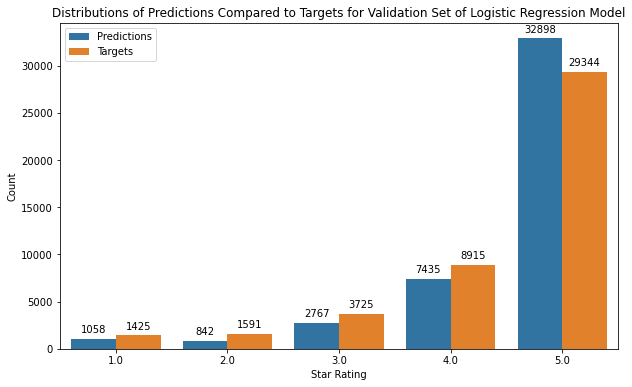

In [ ]:
# Plot of distribution of true target variable values and predictions on validation set.
plt.figure(figsize=(10,6))
plot = sns.countplot(x='value', hue='Prediction vs. Target', order=[1.0, 2.0, 3.0, 4.0, 5.0], data=pd.melt(X_val, value_vars=['prediction','target'], var_name='Prediction vs. Target'))
for p in plot.patches: # Applies annotation on top of bars.
  plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distributions of Predictions Compared to Targets for Validation Set of Logistic Regression Model')
plt.legend(labels=('Predictions','Targets'))
plt.show()

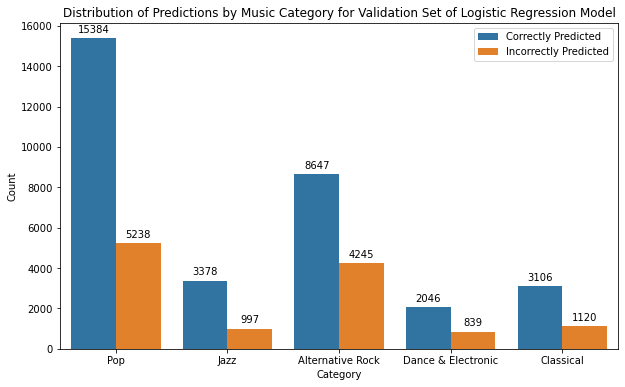

In [ ]:
# Plot of correct and incorrect prediction results.
plt.figure(figsize=(10,6))
plot = sns.countplot(x='category', hue='result', data=X_val)
for p in plot.patches: # Applies annotation on top of bars.
  plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Predictions by Music Category for Validation Set of Logistic Regression Model')
plt.legend()
plt.show()

In [ ]:
# Generating confusion matrix for validation set.
val_results_matrix = confusion_matrix(y_val, LR_TFIDF[2], normalize='true')
val_results_matrix

array([[0.46807018, 0.1122807 , 0.1122807 , 0.08350877, 0.22385965],
       [0.12633564, 0.230044  , 0.25958517, 0.15336266, 0.23067253],
       [0.02308725, 0.05127517, 0.35731544, 0.27436242, 0.29395973],
       [0.00471116, 0.00841279, 0.06079641, 0.41144139, 0.51463825],
       [0.00211287, 0.00170393, 0.0109392 , 0.08117503, 0.90406897]])

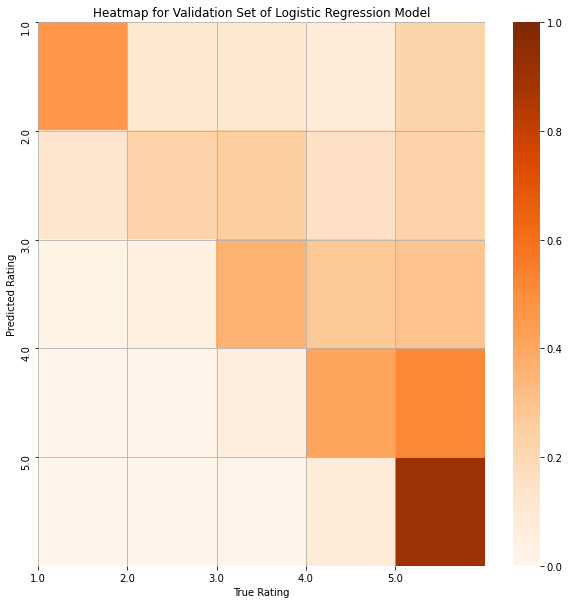

In [ ]:
# Generating heatmap for validation set.
plt.figure(figsize=(10, 10))
sns.heatmap(val_results_matrix, fmt='', vmin=0, vmax=1, cmap='Oranges')
plt.xlabel('True Rating')
x_tick_label = ('1.0', '2.0', '3.0', '4.0', '5.0')
x_minor_ticks = np.arange(0, 5, 1)
plt.xticks(x_minor_ticks,x_tick_label)
plt.ylabel('Predicted Rating')
y_tick_label = ('1.0', '2.0', '3.0', '4.0', '5.0')
y_minor_ticks = np.arange(0, 5, 1)
plt.yticks(x_minor_ticks, x_tick_label)
plt.title('Heatmap for Validation Set of Logistic Regression Model')
plt.grid()
plt.savefig('Multiclass_Results_Heatmap')

## **(6) Final Model Evaluation on Test Data**

The Logistic Regression algorithm with C hyperparameter of 2.0 and 'saga' solver performed the best on the training and validation sets with reasonable computational time compared to the other algorithms. Many algorithms had trouble converging due to the large data size. Logistic Regression's 'saga' solver works well with large datasets compared to other solvers. This algorithm was evaluated on the test data.

In [ ]:
# Final model for test set.
test_pred = LR_TFIDF[1].predict(TFIDF_test)
X_test['test_pred'] = test_pred

<ipython-input-78-e044232b50c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['test_pred'] = test_pred


In [ ]:
# Save predictions with corresponding userID-itemID.

# Create dicts of predictions.
predictions_dict = defaultdict(list)

for index_ in X_test.index:
  reviewerID_itemID = X_test.loc[index_,'reviewerID'] + '-' + X_test.loc[index_,'itemID']
  prediction = X_test.loc[index_,'test_pred']
  predictions_dict[reviewerID_itemID].append(prediction)

predictions_dict2 = {}
for u in predictions_dict:
  predictions_dict2[u] = sum(predictions_dict[u])

# Creates new csv file for predictions.
predictions = open('rating_predictions.csv', 'w')

# Loop runs for every line in csv file.
for l in open('rating_pairs.csv'):

  # Checks if line starts with 'userID'.
  if l.startswith('userID'):

      # Writes the userID-item ID heading.
      predictions.write(l)
      continue
  
  # Checks if userID-itemID combination in the line is in the predictions dictionary. If so, writes the corresponding userID-itemID and prediction.
  u,p = l.strip().split('-')
  p = p.strip(',')
  combo = u + '-' + p
  predictions.write(u + '-' + p + ',' + str(round(predictions_dict2[combo])) + '\n')

The Mean Squared Error on the test set was lower than the strong baseline, which reveals a few conclusions:

1. Logistic Regression is a very suitable algorithm for classification of both text data and categorical data, and generalizes well.

2. Term Frequency - Inverse Document Frequency feature encoding performed better than Bag of Words for a large amount of text data.

3. Limiting TF-IDF to a maximum of 5000 features reduces computational expense considerably while retaining the top features by frequency.